<a href="https://colab.research.google.com/github/LucasCRK/DL_project/blob/Ziv/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There is no way to easily save variable state so I thik we just have to be careful to save regurlaly the model.


In [52]:
!pip install dgl
!pip install networkx
!pip install pin
!pip install gdown

  Using cached https://files.pythonhosted.org/packages/cf/81/f69af6685a26b435558bb7aead39127c38ce7dddb8d734a13db88ae3b9f8/pin-0.1rc1.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [53]:
#Lucas experimenting in how to build graphs
import glob
import numpy as np
import networkx as nx
import torch as th
import matplotlib.pyplot as plt
#from pin import ProteinGraph
import pandas as pd
#from Bio.PDB import PDBList, PDBIO, PDBParser
import os
from networkx.readwrite import json_graph
import json

import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from dgl.data.utils import load_graphs


In [51]:
!unzip '/content/drive/My Drive/Ziv/courses/ML/DL_project/Graphs_2.zip'

Archive:  /content/drive/My Drive/Ziv/courses/ML/DL_project/Graphs_2.zip
   creating: Graphs_2/
  inflating: Graphs_2/.DS_Store      
   creating: __MACOSX/Graphs_2/
  inflating: __MACOSX/Graphs_2/._.DS_Store  
  inflating: Graphs_2/12as.gr        
  inflating: __MACOSX/Graphs_2/._12as.gr  
  inflating: Graphs_2/13pk.gr        
  inflating: __MACOSX/Graphs_2/._13pk.gr  
  inflating: Graphs_2/1tah.gr        
  inflating: __MACOSX/Graphs_2/._1tah.gr  
  inflating: Graphs_2/1tde.gr        
  inflating: __MACOSX/Graphs_2/._1tde.gr  
  inflating: Graphs_2/1tdj.gr        
  inflating: __MACOSX/Graphs_2/._1tdj.gr  
  inflating: Graphs_2/1teh.gr        
  inflating: __MACOSX/Graphs_2/._1teh.gr  
  inflating: Graphs_2/1thg.gr        
  inflating: __MACOSX/Graphs_2/._1thg.gr  
  inflating: Graphs_2/1tht.gr        
  inflating: __MACOSX/Graphs_2/._1tht.gr  
  inflating: Graphs_2/1tkk.gr        
  inflating: __MACOSX/Graphs_2/._1tkk.gr  
  inflating: Graphs_2/1tmo.gr        
  inflating: __MACOSX/

In [ ]:
!tar -xf '/content/drive/My Drive/Ziv/Graphs.tar.gz'

In [ ]:
#json_files = glob.glob("/content/drive/My Drive/PhD/Homework/DL_project/data/json/*.json")

json_files = glob.glob("/content/json/*.json")
#print(len(json_files))
with open(json_files[2], 'r') as json_file:
  print(json_files[2])
  data = json.load(json_file) 
  graph = json.loads(data[0])
  labels = json.loads(data[1])


In [ ]:
graph_l=glob.glob('Graphs/train_ds/*')
graphs=[]
for i in tqdm(graph_l):
    glist, label_dict = load_graphs(i)
    graphs.append(glist)

In [ ]:
nodes_dic={n:n for n in graphs[431][0].nodes().tolist()}
nodes_dic
#nx.draw_networkx_nodes(dgl.to_networkx(graphs[200][0]))

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59}

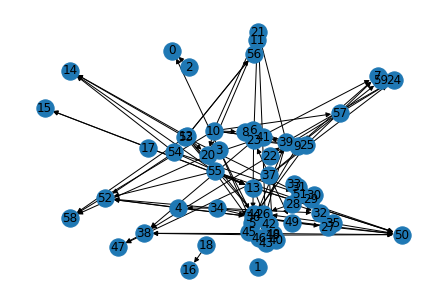

In [ ]:
nxgr=dgl.to_networkx(graphs[431][0])
nx.draw(nxgr,labels=nodes_dic)


In [54]:
class CustomDataset2(Dataset):
  def __init__(self, path):
    graph_l=glob.glob(path+'/*')
    self.graphs=[]
    for i in tqdm(graph_l):
      glist, label_dict = load_graphs(i)
      self.graphs.append(glist)
   
  def __len__(self):
    
    return len(self.graphs)


  def __getitem__(self, idx):
        
    
    return self.graphs[idx][0], self.graphs[idx][0].ndata['cats']

In [ ]:
src = list()
dst = list()

# Get source and destination of edges
for i in  graph["links"]:
  src.append(i['source'])
  dst.append(i['target'])
residues = list(sorted(set(src + dst)))
# Creat map of AA number to nodes with starting idx 0
node_idx  = 0
previous_aa = residues[0]
residue_map = dict()
for i in range(0, len(residues)):
  if residues[i] != previous_aa:
    node_idx += 1
  residue_map[residues[i]] = node_idx
  
  previous_aa = residues[i]
# DGL graph has to start at 0 renumber AA
src = np.array([residue_map[i] for i in src])
dst = np.array([residue_map[i] for i in dst])
print(residue_map)
print(len(residues))
print(src)
print(dst)
#sorted(node_map.keys())

In [ ]:
src = list()
dst = list()

# Get source and destination of edges
for i in  graph["links"]:
  src.append(i['source'])
  dst.append(i['target'])
residues = list(sorted(set(src + dst)))
# Creat map of AA number to nodes with starting idx 0
node_idx  = 0
previous_aa = residues[0]
residue_map = dict()
for i in range(0, len(residues)):
  if residues[i] != previous_aa:
    node_idx += 1
  residue_map[residues[i]] = node_idx
  
  previous_aa = residues[i]

# DGL graph has to start at 0 renumber AA
src = np.array([residue_map[i] for i in src])
dst = np.array([residue_map[i] for i in dst])

#Make Graph bidirectional
u = np.concatenate([src, dst])
v = np.concatenate([dst, src])

# Map features to node id
node_map = dict()
for i in graph["nodes"]:
  if i['id'] in residue_map.keys():
    tmp = dict()
    tmp['label'] = labels[i['id']] 
    #print(i["resi_num"], i["resi_num"])
    node_map[i["id"]] = {**i, **tmp}

# Create DGL object
G = dgl.DGLGraph((u,v))
pos = nx.kamada_kawai_layout(G.to_networkx())
nx.draw(G.to_networkx(), pos, with_labels=True)

label_tensor = th.tensor([node_map[i]['label'] for i in node_map.keys()])
print(label_tensor).shape
# Add features to each node
G.ndata['features'] = th.zeros(len(G), len(node_map[list(node_map.keys())[0]]['features'][0]))
G.ndata['label'] = th.zeros(len(G), len(label_tensor))
#print(G.ndata['features'])
for i in node_map.keys():
  #print(th.tensor(node_map[i]['features'][0]))
  G.ndata['features'][residue_map[i]] = th.tensor(node_map[i]['features'][0])
  G.ndata['label'][residue_map[i]] = label_tensor


In [ ]:
G

In [ ]:
G.nodes[residue_map['C200ASP']]

In [ ]:
len(G.ndata['features'][1])

36

In [ ]:
residue_map['B138SER']

499

In [ ]:
node_map['D200ASP']

In [ ]:
#Lucas end of experiment

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path):
      json_files = glob.glob(os.path.join(path, "*.json"))
      self.graphs=[]
      for fname in tqdm(json_files):
        with open(fname, 'r') as json_file:
          data = json.load(json_file) 
          graph = json.loads(data[0])
          labels = json.loads(data[1])
        
        src = list()
        dst = list()

  # Get source and destination of edges
        for i in  graph["links"]:
          src.append(i['source'])
          dst.append(i['target'])
        residues = list(sorted(set(src + dst)))
  # Creat map of AA number to nodes with starting idx 0
        node_idx  = 0
        previous_aa = residues[0]
        residue_map = dict()
        for i in range(0, len(residues)):
          if residues[i] != previous_aa:
            node_idx += 1
          residue_map[residues[i]] = node_idx
          
          previous_aa = residues[i]
  # DGL graph has to start at 0 renumber AA
        src = np.array([residue_map[i] for i in src])
        dst = np.array([residue_map[i] for i in dst])

  #Make Graph bidirectional
        u = np.concatenate([src, dst])
        v = np.concatenate([dst, src])

  # Map features to node id
        node_map = dict()
        for i in graph["nodes"]:
          if i['id'] in residue_map.keys():
            tmp = dict()
            tmp['label'] = labels[i['id']] 
            node_map[i["id"]] = {**i, **tmp}
  # Create DGL object
        G = dgl.DGLGraph((u,v))
      
        label_tensor = th.tensor([node_map[i]['label'] for i in node_map.keys()])
        #print(label_tensor.shape)

  # Add features to each node
        G.ndata['features'] = th.zeros(len(G), len(node_map[list(node_map.keys())[0]]['features'][0]))
        G.ndata['label'] = th.zeros(len(G), len(label_tensor))
      

        for i in node_map.keys():
          
          G.ndata['features'][residue_map[i]] = th.tensor(node_map[i]['features'][0])
        G.ndata['label'] = label_tensor      

      
        self.graphs.append(G)
        
          
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx], self.graphs[idx].ndata['label']

In [56]:

train_ds=CustomDataset2('/content/Graphs_2/train_ds_try')
valid_ds=CustomDataset2('/content/Graphs_2/valid_ds')
#train_ds = CustomDataset("/content/drive/My Drive/PhD/Homework/DL_project/data/json/") 

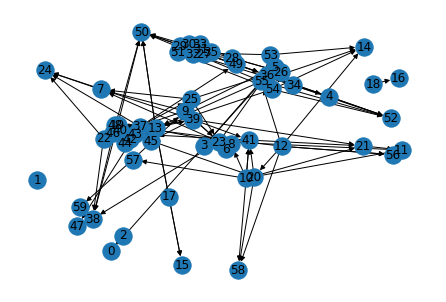

In [ ]:
nodes_dic={n:n for n in train_ds[431][0].nodes().tolist()}
nx.draw(dgl.to_networkx(train_ds[431][0]),labels=nodes_dic)


In [57]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['features'])
    targets = th.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [58]:
class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()
        
        self.edgelayer1=nn.Linear(128*2+21*2,128)
        self.edgelayer2=nn.Linear(128,256)
        
    def forward(self, x):
      #print(x.dst['node_features'].shape,x.src['node_hidden_state'].shape)
      x=th.cat((x.dst['features'], x.dst['node_hidden_state'],x.src['features'], x.src['node_hidden_state']),dim=1)
      #print(x.shape)
      output=F.relu(self.edgelayer1(x))  
        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']
        
        #put them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - 
        
        #you return a dictionary with what you want to "send" to the reciving node
      output=self.edgelayer2(output) 
      return {'edge hidden represetation': output }

    
class NodeNetwork(nn.Module):
    def __init__(self):
        super(NodeNetwork, self).__init__()
        self.nodelayer1=nn.Linear(256+128+21,256)
        self.nodelayer2=nn.Linear(256,128)
        
    def forward(self, x):
      x_sum=th.mean(x.mailbox['edge hidden represetation'],dim=1)
      #print(x_sum.shape, x.data['node_hidden_state'].shape, x.data['node_features'].shape)
      x=th.cat((x_sum,x.data['node_hidden_state'], x.data['features']),dim=1)
      out=F.relu(self.nodelayer1(x))        
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        # return a new hidden state for the node
      out=self.nodelayer2(out)
      return {'node_hidden_state': out }

class NodeNetworkClassifeir(nn.Module):
    def __init__(self):
        super(NodeNetworkClassifeir, self).__init__()
        
        self.nodelayerC1=nn.Linear(21+128,64)
        self.nodelayerC2=nn.Linear(64,1)
        
    def forward(self, x):
      #x_sum=torch.mean(x.mailbox['edge hidden represetation'],dim=1)
      x=th.cat((x.data['features'], x.data['node_hidden_state']),dim=1)
      output=F.relu(self.nodelayerC1(x))  
        
      output=self.nodelayerC2(output) 
      return {'node_class_prediction': output }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
        #self.node_feat_size=g.ndata['features'].shape[1]
        self.node_hid_size=128
        self.node_init = nn.Sequential(
                nn.Linear(21,64),
                nn.ReLU(),
            nn.Linear(64,self.node_hid_size))
        
        self.edge_network = EdgeNetwork()
        self.node_network = NodeNetwork()
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        self.node_classifier = NodeNetworkClassifeir()
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['features'])
        #print(g.ndata['node_hidden_state'].shape)
        for i in range(8):
            
            g.update_all(self.edge_network,self.node_network)
            
        
        #we want to classify the nodes - so finally apply your edge classifier -
        g.apply_nodes(self.node_classifier)
        
        #and extract its output 
        out = g.ndata['node_class_prediction']

        
        return out 

In [59]:
net=Classifier()

In [ ]:
train_ds[0]


(DGLGraph(num_nodes=1936, num_edges=11534,
          ndata_schemes={'h': Scheme(shape=(7,), dtype=torch.float32), 'asa': Scheme(shape=(1,), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float32), 'ss': Scheme(shape=(9,), dtype=torch.float32), 'rsa': Scheme(shape=(1,), dtype=torch.float32), 'cats': Scheme(shape=(), dtype=torch.float64), 'features': Scheme(shape=(21,), dtype=torch.float32)}
          edata_schemes={'rel_type': Scheme(shape=(17,), dtype=torch.float64), 'norm': Scheme(shape=(), dtype=torch.float32)}),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64))

In [ ]:

perd

tensor([[-9.1298e+02],
        [-8.2776e+02],
        [-6.2514e+02],
        ...,
        [-5.0934e-01],
        [-5.7494e-01],
        [-6.7242e-01]], grad_fn=<AddmmBackward>)

In [ ]:
# the basic "graph attention layer" and the way to pass the information from node to node

class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [ ]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [ ]:
#the real model
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [60]:
# loading data here 
data_loader = DataLoader(train_ds, batch_size=20, shuffle=True,
                         collate_fn=collate)
data_loader_test=DataLoader(valid_ds, batch_size=20,shuffle=True,collate_fn=collate)

In [61]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [62]:
if th.cuda.is_available():
    net.cuda()
use_cuda = th.cuda.is_available()
device = th.device('cuda:0' if use_cuda else 'cpu')

In [63]:
##training for simple net
n_epoch = 30
#F1scores=[]

epoch_losses, epoch_val_losses = [], []
for epoch in range(1, n_epoch+1):
    epoch_loss = 0
    iter_batch = 0
    net.train()
    for x, y in data_loader:
      x = x.to(th.device('cuda'))
      y = y.cuda()

      prediction = net(x)
        
      loss = loss_func(prediction, y )
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.detach().item()
      iter_batch += 1
    epoch_loss /= (iter_batch + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    
    
    epoch_val_loss = 0
    iter_batch_val = 0
    net.eval()
    for bg, label in data_loader_test:
      bg=bg.to(th.device('cuda'))
      label=label.cuda()   
      prediction = net(bg)
      loss = loss_func(prediction, label)
      epoch_val_loss += loss.detach().item()
      iter_batch_val += 1
      #F1scores.append(F1_score(prediction, label))
    epoch_val_loss /= (iter_batch_val + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_val_losses.append(epoch_val_loss)
    print('Epoch {}, loss {:.4f}, val_loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

#print(np.mean(F1scores))

Epoch 1, loss 6.8463, val_loss 0.7158
Epoch 2, loss 1.0382, val_loss 0.9042
Epoch 3, loss 0.7562, val_loss 1.0931
Epoch 4, loss 0.6567, val_loss 0.9493
Epoch 5, loss 0.5709, val_loss 0.9571
Epoch 6, loss 0.9626, val_loss 1.0977
Epoch 7, loss 0.9852, val_loss 1.9255
Epoch 8, loss 1.2811, val_loss 1.9388
Epoch 9, loss 1.4518, val_loss 1.1618
Epoch 10, loss 1.4779, val_loss 1.9971
Epoch 11, loss 1.3116, val_loss 1.2257
Epoch 12, loss 0.7490, val_loss 0.7594
Epoch 13, loss 0.5796, val_loss 0.2759
Epoch 14, loss 1.0782, val_loss 1.3891
Epoch 15, loss 1.0480, val_loss 1.0498
Epoch 16, loss 1.0003, val_loss 2.3339
Epoch 17, loss 1.2105, val_loss 0.6353
Epoch 18, loss 0.8635, val_loss 0.6282
Epoch 19, loss 0.6814, val_loss 1.0412
Epoch 20, loss 0.7339, val_loss 0.6147
Epoch 21, loss 0.3826, val_loss 0.4144
Epoch 22, loss 0.4273, val_loss 0.5577
Epoch 23, loss 0.3134, val_loss 0.2854
Epoch 24, loss 0.1993, val_loss 0.1516
Epoch 25, loss 0.1393, val_loss 0.1336
Epoch 26, loss 0.1229, val_loss 0.

In [ ]:
##training.

import time
import numpy as np

g, features, labels, mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

In [94]:
pred=prediction.tolist()
ones=[round(p[0]) for p in pred] 

In [96]:
def F1_score(prediction, label):
  true_pos=0; all_positive=0
  relev_ones=(label==1.).sum(dim=0)
  pred=prediction.tolist()
    #all_positive=(pred == 1.).sum(dim=0)
  for i,l in enumerate(label.tolist()):
    rounded_pred=round(pred[i][0])
    if rounded_pred ==1:
      all_positive+=1
      if l==1: 
        true_pos+=1
       
  if all_positive == 0:
    return(0)
  precision=true_pos/all_positive
  if all_positive-relev_ones >= 0:
    FN=all_positive-relev_ones
  else:
    FN=0
  recall=true_pos/true_pos+FN
  F1_score=(2*(precision*recall)/(precision+recall)) 
  
  return(F1_score) 


In [ ]:
ones

In [98]:
f1=F1_score(prediction,label)
f1

0